# COMA Implementation

This is my implementation of the Counter Factual Multi-Agent Policy Gradients system - COMA. This system was completed entirely by myself with my own research.

The Combat environment is used in this implementation - the wiki is given below and linked [here](https://github.com/koulanurag/ma-gym/wiki/). However, as is shown in the README - I found that the wiki is somewhat incorrect about the reward system.

### Environment Description
![Combat](https://github.com/koulanurag/ma-gym/raw/master/static/gif/Combat-v0.gif)


Combat environment simulates a battle involving two opposing teams in a `20×20` grid. Each team consists of `m = 10` agents and their initial positions are sampled uniformly in a `5×5` square around the team center, which is picked uniformly in the grid.

#### Action Space
At each time step, an agent can perform one of the following actions:
*   move one cell in one of four directions;
*   attack another agent by specifying its ID `j` (there are `m` attack actions, each corresponding to one enemy agent);
*   do nothing.

#### Transition Dynamics
If agent A attacks agent B, then B’s health point will be reduced by 1, but only if B is inside the firing range of A (its surrounding `3×3` area). Agents need one-time step of cooling down after an attack, during which they cannot attack. All agents start with three health points and die when their health reaches 0. A team will win if all agents in the other team die. The simulation ends when one team wins, or neither of the teams win within 40 time steps (a draw).

#### Observation Space
When the input to a model, each agent is represented by a set of one-hot binary vectors `{i, t, l, h, c}` encoding its unique ID, team ID, location, health points, and cooldown. A model controlling an agent also sees other agents in its visual range (`3×3` surrounding area).

#### Reward Settings
The model gets a reward of -1 if the team loses or draws at the end of the game. In addition, it also get a reward of −0.1 times the total health points of the enemy team, which encourages it to attack enemy bots.

#### Enemy Settings
Your model controls one team during training, and the other team consists of bots that follow a hardcoded policy. The bot policy is to attack the nearest enemy agent if it is within its firing range. If not, it approaches the nearest visible enemy agent within the visual range. An agent is visible to all bots if it is inside the visual range of any individual bot. This shared vision gives an advantage to the bot team.

### Download Requirements and Set the Environment
The following command will download the required scripts and set up the environment. 

Execute the following block until you see a WARNING and a button asking to **RESTART RUNTIME**. Click the button and wait for the runtime to restart, **then proceed to the next block of code.**

Note: The below installs are written by the TAs from UCL's Multi-Agent Artificial Intelligence module, however, the actual implementation is written by me - this is indicated below.

In [ ]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git
%cd /content/ma-gym 
!pip install -q -e .

**Run the following block of code to continue environment set-up AFTER you have restarted the RUNTIME from the previous block.**

In [ ]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

In [ ]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
from ma_gym.envs.combat.combat import Combat
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


from functools import reduce
from operator import add

# COMA Implementation
All code written from here is exclusively by myself and is the entire COMA implementation.

COMA - [Counterfactual Multi-Agent Policy Gradients (COMA)](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/view/17193/16614)



Imports

In [ ]:

#The below is to stick the TensorFlow version, since TF version2
#does not have some required funtions (eg .get_session())
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras import optimizers
from keras import backend
from collections import deque
from keras.layers import Activation, Dense
from collections import deque
from copy import deepcopy
import random
import numpy as np
import sys
import time



In [ ]:
# Since this method uses the "global state" and has a lot of variables,
#it is best to create a new class for the buffer.

class Replay_Buffer():
  def __init__(self, buffer_size):
    self.max_length = buffer_size
    # self.data = deque(maxlen = buffer_size)

    """
    Originally, a deque was used as the buffer container.
    However,l the rest of the coe has been created to not use random sample
    (as this would be exceedingly difficult to process due to the
    new COMA critic setup) and deques have O(n) complexity
    when indexing middle values - a regular buffer size
    is 100,000 values and thus this hugely slows the system down.
    Therefore, a dictionary (which has O(1) complexity for indexing 
    middle values) has been selected, and a custom addition to the 
    add_buffer function has been included to implement a max length
    attribute.

    Key: index
    Value: List of Data from that step
    
     """
    self.data = {}

    self.tracker = 0 #this tracks additions to the dictionary

  def Add_to_Buffer(self, prev_obs, prev_act, obs, curr_act, rewards, done):
    """ Since the overall state, as well as the observation,
    of this system is so large, it is best to organise a reasonable
    addition to the buffer in this separate function
    
    The contents of the buffer should be as follows:
    - Previous State
    - Previous Actions
    - Current State
    - Current actions
    - Group reward (for that step)
    - Done 

    Timestep not included
    """

    addition_list = [] #the list which will be added to the buffer

    #add the previous state
    addition_list.append(prev_obs)

    #add the previous actions taken
    addition_list.append(prev_act)

    #add the current state
    addition_list.append(obs)

    #add the current actions
    addition_list.append(curr_act)

    #add the whole system reward
    addition_list.append(sum(rewards)/10)
    #Taking the average reward, instead of the summative, which is far higher

    #add done
    addition_list.append(done)

    #append to the deque object
    # self.data.append(addition_list)



    #now, if the tracker is potentially going to go over the maximum
    #size for the buffer, it should be reset to zero

    if self.tracker >= self.max_length: 
      self.tracker = 0

    #add as a new key-value pair to the dictionary
    self.data[self.tracker] = addition_list

    self.tracker += 1


  def Return_all_current_actions(self, index):
    #access and return the current actions of the specified index
    return self.data[index][3]

  def Return_all_current_actions_excl_agent(self,index,agent):
    return [x for i, x in enumerate(self.data[index][3]) if i != agent-1] #-1 for indexing

  def Return_current_state(self,index):
    return self.data[index][2]

  def Return_current_agent_state(self,index,agent):
    return self.data[index][2][agent-1]

  def Return_all_previous_actions(self,index):
    return self.data[index][1]
  
  def Return_reward(self,index):
    return self.data[index][4]

  def Return_done(self,index):
    return self.data[index][5]

  def Return_previous_agent_action(self,index,agent):
    return self.data[index][1][agent-1]

In [ ]:
class Coma_System:

  def __init__(self):
    self.env = wrap_env(Combat(grid_shape=(20, 20), n_agents=10, n_opponents=10))
    self.sess = tf.Session() #this instantiates a TensorFlow session for us to use
    keras.backend.set_session(self.sess)
    print("action meanings",self.env.get_action_meanings())
    print("self.env.n_agents",self.env.n_agents)
    #each agent needs its own action-observation history, which conditions its own policy.
    self.input_shape = self.env.n_agents*150
    self.trace_decay = 0.8 #lambda in the paper, for TD error - the credit assignment variable.
    self.discount_factor = 0.99 #gamma
    self.n_of_actions = 15
    
    self.max_buffer_size = 100000
    
    self.buffer = Replay_Buffer(self.max_buffer_size)
    self.minibatch_size = 32

    #instantiating networks
    self.actor_learning_rate = 1e-6
    self.critic_learning_rate = 1e-5
    #critic should have higher LR than actor - it is teaching
    self.critic_model = self._Create_Critic(1670,15) #input shape and action space
    self.actors = self._Instantiate_All_Actors(10,152,15) #dictionary of actors
    #1670 and 152 above are the networks' input shapes, derived heuristically.

    self.target_network = keras.models.clone_model(self.critic_model)
    self.target_network_update_steps = 100
    self.actor_critic_update_frequency = 32

    self.training_episodes = 2000 
    self.exploration_episodes = 200
    self.epsilon_min = 0.1
    self.epsilon_max = 0.99
    self.epsilon_projection = -0.2 #what the linear interpolation "aims" for.
    self.testing_episodes = 100

    

    self.episodes_trained = []
    self.critic_loss = []
    
    self.sess.run(tf.global_variables_initializer())

  
  def _Create_Critic(self, input_dimensions,n_of_actions):

    #INPUT to this system defined in COMA paper

    #OUTPUT to this system must be the (15) Q values for all possible 
    #actions which the agent we're considering could take.

    """ From Paper: use a centralised critic that conditions on the true global states,
    if it is available,or the joint action-observation histories τ otherwise. """

    keras.backend.set_session(self.sess)
    model = Sequential() #neuron numbers gained from linked GitHub (oxwhirl)
    model.add(Dense(128, input_dim=input_dimensions, activation="relu"))
    model.add(Dense(128,activation = "relu"))
    model.add(Dense(n_of_actions,activation = "linear"))
    adam_opt = keras.optimizers.Adam(learning_rate = self.critic_learning_rate,clipnorm=1.)
    model.compile(loss='mse',optimizer=adam_opt)
    return model

  def _Build_Critic_Input(self,index,Id = None): #agent id is none by default (during training)
    """This function builds the ijnput whicht eh critic should be trained on.
    This function should be used when analysing individual components
    of the replay buffer, ie its input should be a replay buffer index set.


    This input shoiuld include:
    

    - selected agent ID(during training, we can randomise this, becomes useful in baseline)
    - ALL actions of the agents EXCLUDING the selected agent (14 total)
    - The global state 
    - The selected agent's observation
    - All agents' actions from the previous timestep
      """

    """ 
    I need a current and a "future" critic input.
    We need the future one in order to utilise TD(1) learning.
    TD(lambda) is implemented in the COMA paper, but TD(1) is implemented
    here to create a workflow.
    """

    critic_input = []

    if Id == None:
      Id = random.randint(1, self.env.n_agents)
    critic_input.append(Id)
    #attach all current actions excluding selected agent
    critic_input += self.buffer.Return_all_current_actions_excl_agent(index,Id)

    #The global state is currently assumed to be just a list of ALL observations
    #attach the global state
    critic_input += self._Unravel_Observation(self.buffer.Return_current_state(index))

    #attach current agent observation
    critic_input += self.buffer.Return_current_agent_state(index,Id)

    #attach all previous observations
    critic_input += self.buffer.Return_all_previous_actions(index)

    #######Define future critic input
    """ TODO: Check if there IS a future input - the system could just be done.
    This could be a downfall of the system.

    Q: if there is no future input, what should be done? This is what prevented
    this feature being implemented"""
    future_critic_input = []

    #attach id
    future_critic_input.append(Id)

    #attach all current actions excl selected agent
    future_critic_input += self.buffer.Return_all_current_actions_excl_agent(index+1,Id)

    #attach global state
    future_critic_input += self._Unravel_Observation(self.buffer.Return_current_state(index+1))

    #attach current agent observation
    future_critic_input += self.buffer.Return_current_agent_state(index+1,Id)

    #attach all previous observations
    future_critic_input += self.buffer.Return_all_previous_actions(index+1)

    """Now, in order to find the value-based targets we need the future rewards and future done
    although these are not inputs to the critic network and just should be returned separately
    (see return statement)"""

    future_reward = self.buffer.Return_reward(index+1)
    future_done = self.buffer.Return_done(index+1)



    return critic_input, future_critic_input, future_reward, future_done
  

  def _Train_Critic(self):
    """ Note that right now, I am actually implementing TD(1) (next-state
    TD) instead of TD(lambda), as is implemented in the paper.
    This system is simpler to implement and will allow me to discretise a 
    workflow more efficiently than being stuck on the TD(lambda) implementation
    for a long time, as it is not one of the key contributions to this paper
    and thus is not the focus point of this implementation - change this if 
    I have time.
    
    
    The current difference between this training and the training which was
    done in my DQN algorithm is that I am bootstrapping the predicted Q values
    (from a target network too!) rather than the bootstrapping each value, V.
    """


    """
    Steps:
    - Predict future Q values from future state (AFTER the first action)
    - Find the target for each of these Q values, using the global reward.
      Abive target = reward+self.discount_rate*predicted_Q value
      for each Q value.
      Q values are predicted by target network.
    
    
     """


    #In order to train the critic, we could just randomyl select an agent that we are
    #"considering" at that time.This will then allow us to find targets with reference to this agent

    #first thing is to randomly sample from the deque and build the critic input

    for i in range(self.minibatch_size): 
      index = random.randint(0, len(self.buffer.data)-3)

      critic_input_row, future_critic_input_row, future_reward_row, future_done_row = self._Build_Critic_Input(index)

      if i == 0:
        critic_input = critic_input_row
        future_critic_input = future_critic_input_row
        future_reward = future_reward_row
        future_done = future_done_row
      else:
        critic_input = np.vstack((critic_input,critic_input_row))
        future_critic_input = np.vstack((future_critic_input,future_critic_input_row))
        future_reward = np.vstack((future_reward,future_reward_row))
        future_done = np.vstack((future_done,future_done_row))

    #Now we must use the target network to get the predicted future Q values for the specified agent (see TD(0) eqn): 
    #https://medium.com/@violante.andre/simple-reinforcement-learning-temporal-difference-learning-e883ea0d65b0

    Predicted_Q_Values = self.target_network.predict(future_critic_input) #shape batch_sizex15 (action numbers)

    #Now we must define the targets for the above predicted Q values

    for i in range(self.minibatch_size):
      #since we are using Q as the targets here, instead of V
      #(as the paper uses Q and says that it gives better results)
      Q_row = Predicted_Q_Values[i,:] #one state's predicted Q values
      done_row = future_done[i,:]  #corresponding to above state, same as reward too

      if all(done_row):
        
        target_row = future_reward[i] #should be 15-long - add the [0] as the there was a bug with the sizes.
        #since we are using Q, we need the output of this to be 15 long
        target_row = list(target_row) * self.n_of_actions #distribute average reward across action space
      else:
        target_row = future_reward[i] + self.discount_factor * Q_row # Using Q, not V

      #now create the targets matrix
      if i == 0:
        targets = target_row
      else:
        targets = np.vstack((targets,target_row))

    class LossHistory(keras.callbacks.Callback): #This class is from the Keras website and allows for the loss to be recorded
      def on_train_begin(self, logs={}):
          self.losses = []

      def on_batch_end(self, batch, logs={}):
          self.losses.append(logs.get('loss'))

    history = LossHistory()
    
    #now that we have the targets and the input, let's fit the model.
    history = self.critic_model.fit(critic_input,targets, verbose = 0, batch_size = self.minibatch_size, epochs = 200)
    mean_loss = np.mean(history.history['loss'])
    self.critic_loss.append(mean_loss)



  """We make the below custom loss function in order to use Keras, Keras.backend and tensorFlow
    to find our loss of gradients (needed in policy network optimisation and A2C), without finding them
    manually, which can lead to error. """

  def _my_log_loss(self,y_true,y_pred):
    # This allows us to input actions and advantages into the Keras API.
    action_taken = y_true[:,1:]
    advantages = y_true[:,0]

    loss = keras.backend.log(keras.backend.sum(y_pred * action_taken,axis=1,
                                               keepdims=True) + 1e-5) * keras.backend.stop_gradient(advantages)
    #It is highly important that the action_taken is the ONE-HOT version:
    # eg. [0,0,0,1,0,0,0,0], where 1 shows the index of the action taken
    
    return -loss #we want gradient ascent, not descent

  

  def _Create_Actor(self,input_dimensions,n_of_actions):
    #Each agent should have its own actor

    keras.backend.set_session(self.sess)
    model = Sequential()
    model.add(Dense(128, input_dim=input_dimensions, activation="relu"))
    model.add(Dense(128,activation = "relu"))
    model.add(Dense(n_of_actions,activation = "softmax")) #Must be softmax since it outputs probabilities!
    adam_opt = keras.optimizers.Adam(learning_rate=self.actor_learning_rate)  #default lr is 0.001

    model.compile(loss= self._my_log_loss,optimizer=adam_opt)
    return model

  def _Instantiate_All_Actors(self,n_of_agents,input_dimensions,n_of_actions):
    """ 
    COMA requires N actor networks to work for N agents,
    therefore these will be stored in a dictionary
    key: agent ID
    value: actor network
    """
    actors = {}

    for i in range(n_of_agents): #loop's i goes from 0 to 9
      model = self._Create_Actor(input_dimensions,n_of_actions)
      actors[i+1] = model #i+1 so we get keys 1 - 10, coinciding with agent IDs
    return actors
  
  def _Build_Actor_Input(self,index,agent):
    """ 
    The actor input consists of the following:

    - Current Agent Observation
    - Current Agent ID
    - Current Agent's Previous action

    """

    actor_input = []

    #add the current agent observation
    actor_input += self.buffer.Return_current_agent_state(index,agent)

    #add the current Agent ID
    actor_input.append(agent)

    #add the current agent's previous action
    actor_input.append(self.buffer.Return_previous_agent_action(index,agent))

    return actor_input

  def _Build_Actor_Input_Without_Buffer(self,agent_observation,agent,previous_agent_action):
    """ 
    The actor input consists of the following:

    - Current Agent Observation
    - Current Agent ID
    - Current Agent's Previous action

    """

    actor_input = []

    #add the current agent observation
    actor_input += agent_observation

    #add the current Agent ID
    actor_input.append(agent)

    #add the current agent's previous action
    actor_input.append(previous_agent_action)

    return actor_input



  def _Define_Advantage(self,index,agent): 
    """when we train the actor, we should train it via minibatch gradient ascent, to keep the data i.i.d
    Q: would this create a problem in the temporal nature of the actor optimisation?
    (ie it may be optimising from data of its PREVIOUS policy)
    The Q values here are based off of the whole true space """

    #First part is to return all of the Q values from the critic network
    critic_input_row, _, _, _ = self._Build_Critic_Input(index,agent) #only need the current critic input!
    
    critic_input_row = np.array([critic_input_row])# this must be defined as a batch, even though it is just of size 1

    Q_values = self.critic_model.predict(critic_input_row) #these are whole Q values

    #Now we must define the action which was actually taken after assessing these Q values
    actual_agent_action_taken = self.buffer.Return_all_current_actions(index)[agent-1]

    #Now define the actual whole Q value for the system when this action was picked
    Q_s_u = Q_values[0][actual_agent_action_taken] #this is what the actual actor is PICKING to do!

    #Now we must use the current actor model to define the probability that each action will be chosen:
    current_actor = self.actors[agent]

    current_actor_input = self._Build_Actor_Input(index,agent)
    current_actor_input = np.array([current_actor_input])

    probabilities = current_actor.predict(current_actor_input) 
    #Now this output should be 15-long list of probabilitites that each action will be picked
    
    taken_action_probability = probabilities[0][actual_agent_action_taken]
    #the probability that the ACTUAL action taken was to be taken.
    
    
    #Now we must loop through all of the available actions:

    baseline_summation = 0
    possible_actions = np.arange(0,15)
    Advantage = []
    


    #This is where much of the innovation of the paper is - creating the counter-factual baseline.
    # Advantage = Q - Baseline
    #Q values come from the critic!


    for i in range(len(Q_values[0])):
      current_Q_value = Q_values[0][i] #q value for the current action

      current_action_probability = probabilities[0][i]

      baseline_summation += current_action_probability * current_Q_value

    Advantage_component = Q_s_u - baseline_summation 

    return Advantage_component, actual_agent_action_taken, Q_values[0]
    


  def _Train_Actors(self):
    """ 
    This code is used to train all of the actors during the training stage.
    During the execution stage, this is not needed. This just updates the policies.
    """
    for agent in self.actors: #loop through all agents - their models are indexed in the advantage function
      gradient_sum = 0

      #Now specify the current agent's model
      current_agent_model = self.actors[agent]

      for i in range(self.minibatch_size): #we are training through minibatch gradient ASCENT
        
        #Firstly, a random index from the buffer must be selected
        index = random.randint(0, len(self.buffer.data)-3) #selecting the final value can lead to errors

        #now find the input to the actor system
        actor_input_row = self._Build_Actor_Input(index,agent)
        advantage_row, agent_action, agent_Q_values_row = self._Define_Advantage(index,agent)
        one_hot_agent_actions_row = [0] * self.n_of_actions
        one_hot_agent_actions_row[agent_action] = 1
        if i == 0:
          actor_input = actor_input_row
          advantage = advantage_row
          one_hot_agent_actions = one_hot_agent_actions_row
          agent_Q_values = agent_Q_values_row
        else:
          actor_input = np.vstack((actor_input,actor_input_row))
          advantage = np.vstack((advantage,advantage_row))
          one_hot_agent_actions = np.vstack((one_hot_agent_actions,one_hot_agent_actions_row))
          agent_Q_values = np.vstack((agent_Q_values,agent_Q_values_row))
          #per agent we should have a scalar advantage

      actor_input = np.matrix(actor_input).reshape((self.minibatch_size,len(actor_input[0])))


      # This allows us to input the actions and advantages directly into the Keras API.

      advantages_and_actions = np.concatenate([advantage,one_hot_agent_actions],axis = 1) 
      #axis = 1 means that they will be side by side - first value is advantage!

      current_agent_model.fit(actor_input, advantages_and_actions , verbose = 0, batch_size = self.minibatch_size, epochs = 200)


  def Train_Policy(self):

    env = self.env

    actions = [4] * self.env.n_agents 
    #this is an initial (NOOP) action, needed since the action acts recurseively (to maintain buffer properties)

    overall_steps = 0 #counts the steps across all episodes and iterations
    self.total_rewards = []
    start_time = time.time()
    beginning = time.time()
    for episode in range(self.training_episodes):
      elapsed_time = time.time() - start_time
      total_time = time.time() - beginning
      start_time = time.time()
      # print("elapsed time for this episode",elapsed_time)
      # print("total elapsed time",total_time)
      if episode % 100 == 0:
        print("episode ",episode, "out of", self.training_episodes)
      # print("buffer length",len(self.buffer.data))
      
      ep_reward = 0
      observations = env.reset()
      done = [False for _ in range(env.n_agents)] #instantiation for the loop


      #ANNEALING EPSILON
      if episode < self.exploration_episodes:
          self.epsilon = 1.1
      else: #don't anneal epsilon during random exploration 
          max_ep = self.training_episodes-self.exploration_episodes
          ep = episode-self.exploration_episodes
          epsilon = ((max_ep-ep)/(max_ep))*(self.epsilon_max-self.epsilon_projection)+self.epsilon_projection
          self.epsilon = np.max([self.epsilon_min,epsilon])
      
      # print("epsilon",self.epsilon)
      timestep_in_episode = 0
      actions = [4] * self.env.n_agents
      #this is an initial (NOOP) action, needed since the action acts recurseively (to maintain buffer properties)

      while not all(done):
        timestep_in_episode += 1
        overall_steps += 1

        previous_observations = observations #for buffer
        previous_actions = actions #for buffer
  
        if random.random() < self.epsilon:
          actions = env.action_space.sample() #random action

        else:
          actions = []
          for agent, current_actor in self.actors.items():

            agent_observation = observations[agent-1]
            previous_agent_action = previous_actions[agent - 1] 
            #-1 becuse agents in my dict are 1 - 10, not index values (0 - 9)

            actor_input = self._Build_Actor_Input_Without_Buffer(agent_observation,agent,previous_agent_action)
            
            actor_input = np.array([actor_input])
            probabilities = current_actor.predict(actor_input)
            probabilities = probabilities[0]
            action = np.random.choice(self.n_of_actions,1,p = probabilities) #pick an action based on the outputted probabilities
            actions.append(action)


        if not isinstance(actions[0],int): 
          #to fix a bug where action numbers are put into arrays, caused by custom loss function?
          actions = [x[0] for x in actions]

        observations, rewards, done, info = env.step(actions)

        """
        The description given at the top of this section, about the combat environment is taken
        directly from the ma gym wiki. HOWEVER, from going through the ma gym source code, I am 
        pretty certain the description is incorrect. The source code states that the reward 
        is ACTUALLY += 1 if our team hits an enemy and -= 1 if the enemy team hits us.
        This does NOT encourage the agents to fight, but ijn fact encourages our team to run
        away, as any random exchange which could potentially encourage fighting is likely won
        by the hardcoded team.
        
        The below code attempts to fix this issue as a supplementary reward, however,
        without a way to get rid of the in-built reward, this supplementary method actually detriments
        performance and hence has been omitted, but kept here for method reference
        """


        self.buffer.Add_to_Buffer(previous_observations, previous_actions, observations, actions, rewards, done)

        ep_reward += sum(rewards)

        #exploration episodes to properly populate the buffer, not train the networks
        if overall_steps % self.actor_critic_update_frequency == 0 and episode > self.exploration_episodes: 
          #update the actor and the critic routinely, not constantly after each step
          self._Train_Critic()
          self._Train_Actors()
          self.episodes_trained.append(episode) #To plot the critic loss

        if overall_steps % self.target_network_update_steps == 0 and episode > self.exploration_episodes:
          #update the target network
          self.target_network = keras.models.clone_model(self.critic_model)
      # print("ep reward: ",ep_reward)
      # print("enemy healths: ",env.opp_health.values())
      self.total_rewards.append(ep_reward) #to plot the reward

    env.render()
    env.close()
    # To improve the training efficiency, render() is not necessary during the training.
    # We provide the render and video code here just want to demonstrate how to debugging and analysis.
    # show_video()
    #show_video() CAN crash the system on Google Collab due to usage restrictions



  def Test_Policy(self): 
    #majoritively the same as training, except no random actions or training - just using actor networks.
    env = self.env

    actions = [4] * self.env.n_agents
    overall_steps = 0 #counts the steps across all episodes and iterations
    self.test_rewards = []
    start_time = time.time()
    beginning = time.time()
    for episode in range(self.testing_episodes):
      elapsed_time = time.time() - start_time
      total_time = time.time() - beginning
      start_time = time.time()
      # print("elapsed time for this episode",elapsed_time)
      # print("total elapsed time",total_time)
      if episode % 50 == 0:
        print("testing episode ",episode, "out of", self.testing_episodes)
      # print("buffer length",len(self.buffer.data))
      
      ep_reward = 0
      observations = env.reset()
      done = [False for _ in range(env.n_agents)] #instantiation for the loop

      timestep_in_episode = 0
      actions = [4] * self.env.n_agents 
      while not all(done):
        timestep_in_episode += 1
        overall_steps += 1

        previous_observations = observations #for buffer
        previous_actions = actions #for buffer 
        
        actions = []
        for agent, current_actor in self.actors.items():
          agent_observation = observations[agent-1]
          previous_agent_action = previous_actions[agent - 1] 
          #-1 becuse agents in my dict are 1 - 10, not index values (0 - 9)

          actor_input = self._Build_Actor_Input_Without_Buffer(agent_observation,agent,previous_agent_action)
          
          actor_input = np.array([actor_input])
          probabilities = current_actor.predict(actor_input)
          probabilities = probabilities[0]
          action = np.random.choice(self.n_of_actions,1,p = probabilities) 
          #pick an action based on the outputted probabilities

          actions.append(action)

        if not isinstance(actions[0],int): 
          #to fix a bug where action numbers are put into arrays, caused by custom loss function?
          actions = [x[0] for x in actions]

        observations, rewards, done, info = env.step(actions)

        ep_reward += sum(rewards)
        
      # print("ep reward: ",ep_reward)
      
      self.test_rewards.append(ep_reward)
    env.render()
    env.close()
    # To improve the training efficiency, render() is not necessary during the training.
    # We provide the render and video code here just want to demonstrate how to debugging and analysis.
    # show_video()
    #show_video() CAN crash the system on Google Collab due to usage restrictions





    
  def _Unravel_Observation(self,obs): #this function works!
    #The critic runs on the entire state of our team, and thus the observation must be unravelled into
    #one long string, to input into a single NN

    #Since we do not have a global state available,this must be achieved by concatenating observations
    #Source: COMA paper (see report below).

    result_obs = [0 for _ in range(len(obs[0])*len(obs))] #zeros list of correct length

    #now loop through all values methodically
    step = 0
    for i in range(len(obs)):
      for j in range(len(obs[0])): #obs[0] has same length as obs[1] etc etc
        result_obs[step] = obs[i][j]
        step += 1
    return result_obs


COMA = Coma_System()
COMA.Train_Policy() #execute




#### Plot the Learning Curve

In [ ]:
fig, ax = plt.subplots()

number_of_episodes = len(COMA.total_rewards)
episode_matrix = np.arange(0,number_of_episodes)

ax.plot(episode_matrix, COMA.total_rewards)
ax.set_title("Learning Curve")
ax.set_ylabel("Episodic Reward (Cumulative for All Agents)")
ax.set_xlabel("Episodes")

Plot the Critic Loss

In [ ]:
fig, ax = plt.subplots()
print("critic_loss",COMA.critic_loss)
print("episodes trained",COMA.episodes_trained)

ax.plot(COMA.episodes_trained,COMA.critic_loss)

ax.set_title("Critic Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Episodes Trained")

""" 
My report (below) mentions the sporadic critic loss, this can be seen on this graph.
"""

Testing Actor/Agent/Policy System:

In [ ]:

""" 
This tests the trained policy / actor networks.
It is placed after the training and train-plots because
strenuous computational work is more likely to crash Google Collab
than plotting etc, which after training is heavily disadvantageous.
"""


COMA.Test_Policy()


Plot the Testing Curve

In [ ]:
fig, ax = plt.subplots()

number_of_episodes = len(COMA.test_rewards)
episode_matrix = np.arange(0,number_of_episodes)

ax.plot(episode_matrix, COMA.test_rewards)
ax.set_title("Testing Curve")
ax.set_ylabel("Episodic Reward (Cumulative for All Agents)")
ax.set_xlabel("Episodes")

"""
System rewsrds can vary due to randomness (spawn, instantiations etc),
hence the neeed for this curve, as the reward is not always necessarily the 
same, even with the same policy/actor networks.
"""

Show Video

In [ ]:
"""
This shows the behaviour of the trained network.
It is outside of the main training and testing loop
since it often causes Google Collab crashes due
to usage limits. 
"""

show_video()

#### Analysis on Performance

COMA$^{[6]}$ gives three major contributions:

- Global Critic
- Counterfactual Baseline
- Novel Critic Representation

In IAC$^{[7]}$, N value-based critics estimate the value of agent N's states and N policy gradient-based$^{[3]}$$^{[4]}$$^{[6]}$ actors are used to determine and execute action probabilities. Since the critic is used to learn the Q-Values of the system and not to execute actions, a global critic can take advantage of the entire system state and encourage agent cooperation$^{[9]}$. There is still N actors to execute their own action policies. In my implementation, the critic used a standard TD(0)$^{[1]}$ error - this differs from the paper, which uses a TD(lambda) method$^{[7]}$$^{[6]}$ and quotes its lambda value (0.8; closer to TD(1)) as a hard-to-tune variable$^{[6]}$. This is likely the downfall of the implemented system (the sporadic critic losses supports this theory).

TD(0) is used due to the abnormal critic representation making the buffer-data flow inefficient.

Baselines place the state-value in a local context to determine its true value/influence, which encourages convergence/accuracy. This determination of how to assign reward based on a single agent's action is the credit assignment problem. The counterfactual baseline achieves credit assignment with no extra simulation or domain knowledge required. It assesses how all possible actions that agent N could take would affect the Q value of the system state. The COMA advantage function is below - showing the Q-value of the actual state that was selected, minus the counterfactual baseline$^{[6]}$:

> $A^{a}(s,\textbf{u}) = Q(s,\textbf{u}) - \sum_{u^{\prime a}}\pi^{a}(u^{\prime a} | \tau^{a})Q(s,(\textbf{u}^{-a},u^{\prime a}))$

Where $\textbf{u}$ is the group's chosen action, $u^{\prime a}$ is one of agent N's possible actions, $\textbf{u}^{-a}$ represents all agents' actions, except the current agent's. $\pi^{a}(u^{\prime a}|\tau^{a})$ represents the policy network, which mathematically is the probability that action $u^{\prime a}$ will be selected.

The counterfactual baseline is calculated in the define_advantage function. The advantage is predicted by the critic, which influences the actor's gradient (through the boostrapping of the critic) - the critic is teaching the actors.

COMA uses a novel critic whereby not only the whole system state is input, but also a particular agent and its observation is input too. Therefore, the critic outputs the overall state's Q values, should the agent N take any of its available actions, deriving the agent's entire action-value data in one pass, efficiently creating the baseline. In my implementation, since training was done via minibatch gradient descent, a random agent was "selected" to be agent N in each training step, so the critic could learn its representation - in predicting, the agent-set was iterated across non-randomly. A target network was also used to make the predictions in the critic training, to encourage stability. The critic predicted Q-values, not V as the former cites higher accuracy$^{[6]}$. Both actor and critic were implemented using the inputs described in COMA's diagrams (Left: Actor, Right: Critic)$^{[6]}$:


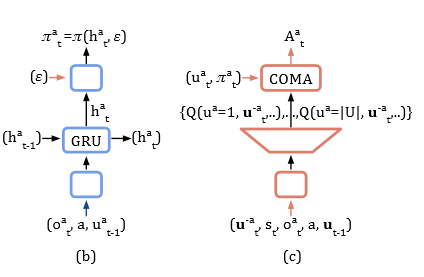

A custom loss function$^{[2]}$$^{[5]}$ has been implemented to train the actors, using COMA's gradient function$^{[6]}$:

> $g_{k} = \mathbb{E}[\sum_{a}\triangledown_{\theta}log\pi^{a}(u^{a}|\tau^{a})A^{a}(s,\textbf{u})]$
Where $\pi$ is the policy's parameters (NN weights).

Depending on the seed/optimisation, the implementation can (rarely) converge on constant zero-reward:

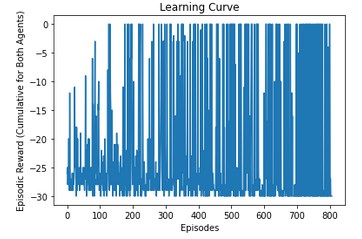

The replay memory/buffer is a dictionary, minimising time-complexity (indexing is O(1))$^{[8]}$.

**Words: 498**

**Sources:**
IEEE Referencing used. All references were most recently accessed on 27th April 2020.

[1]  A.Violante, “Simple reinforcement learning: Temporal difference learning.” https://medium.com/@violante.andre/simple-reinforcement-learning-temporal-difference-learning-e883ea0d65b0.

[2]  nevkontakte, “mountain_car_v3_tf_keras.” https://gist.github.com/nevkontakte/2db02b57345ca521d541f8cdbf4081c5.

[3]  A.L.Ecoffet, “An intuitive explanation of policy gradient.” https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c.

[4]  MathWorks, “Actor-critic agents.” https://uk.mathworks.com/help/reinforcement-learning/ug/ac-agents.html#mw_2067355b-96d6-452d-bcd6-18d6e4b8614f.

[5]  LuEE-C,   “A2c-keras.” https://github.com/LuEE-C/A2C-Keras/blob/master/Main.py.

[6]  J.  N.  Foerster,  G.  Farquhar,  T.  Afouras,  N.  Nardelli,  and  S.  Whiteson,“Counterfactual multi-agent policy gradients,”CoRR, vol. abs/1705.08926,2017.

[7]  oxwhirl,  “Python  multi-agent  reinforcement  learning  framework.” https://github.com/oxwhirl/pymarl.

[8]  Python, “Time complexity.” https://wiki.python.org/moin/TimeComplexity.


[9]  Microsoft,  “Counterfactual  multi-agent  policy  gradients.” https://www.youtube.com/watch?v=3OVvjE5B9LU&t=1406s.


